In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/jeff/projects/fastai')

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
import torch, torchvision, torchtext
from torch import nn, cuda, backends, FloatTensor, LongTensor, optim
import torch.nn.functional as F
import pandas as pd

In [6]:
img_dir = '/home/jeff/notebooks/kaggle/dogbreed/train/'
img_test_dir = '/home/jeff/notebooks/kaggle/dogbreed/test/'
path = '/home/jeff/notebooks/kaggle/dogbreed/pytorch/'
csv_fname = '/home/jeff/notebooks/kaggle/dogbreed/labels.csv'

In [7]:
df = pd.read_csv(csv_fname)

In [8]:
val_idxs = get_cv_idxs(df.shape[0])

In [9]:
sz=224

In [10]:
tfms = tfms_from_model(resnext50, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [11]:
data = ImageClassifierData.from_csv(path, img_dir, csv_fname, bs=64, tfms=tfms,
                                    val_idxs=val_idxs, suffix='.jpg', 
                                    test_name=img_test_dir, continuous=False, 
                                    skip_header=True, num_workers=8)

Grab resnext50 and modify it to have an fc layer and then softmax layer for predictions.

Note: I want to try keeping the 1000 preds from the original model since it already includes predictions for dog breeds.  The idea is we won't have to retrain the same FC layers that are already really good at identifying these dog breeds.

In [12]:
m = resnext50(True)

In [13]:
fc_layers = [nn.BatchNorm1d(1000), 
             nn.Linear(1000,512),
             nn.ReLU(),
             nn.BatchNorm1d(512),
             nn.Linear(512,120),
             nn.LogSoftmax()]
m = nn.Sequential(*([m]+fc_layers))

In [14]:
bm = BasicModel(m.cuda(), name='resnext50')

In [15]:
learn = ConvLearner(data, bm)

Freeze all of resnext50
- the layers we added (fc_layers) should be trainable
- the resnext50 layers should not be

In [16]:
learn.freeze_to(1)

Confirm architecture and confirm correct layers are trainable

In [17]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [18]:
learn.lr_find()

A Jupyter Widget

 97%|█████████▋| 124/128 [00:21<00:00,  5.73it/s, loss=12.9]

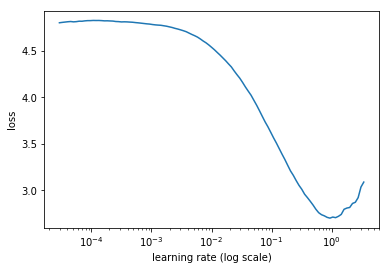

In [19]:
learn.sched.plot()

LR Find Looks good.  Run fit for 3 epochs w/ lr = .3

@Apil - validation loss will blow up during training to infinitiy...sorry you have to scroll all the way down to see it you can search for "nan"

In [21]:
learn.fit(.3,3)

A Jupyter Widget


 99%|█████████▉| 127/128 [00:22<00:00,  5.73it/s, loss=0.442]


100%|██████████| 128/128 [00:22<00:00,  5.75it/s, loss=0.441]
                                                             [ 0.       0.44091      nan  0.00833]

 98%|█████████▊| 125/128 [00:22<00:00,  5.68it/s, loss=0.383]


100%|██████████| 128/128 [00:22<00:00,  5.74it/s, loss=0.384]
                                                             [ 1.       0.38414      nan  0.00833]

 97%|█████████▋| 124/128 [00:23<00:00,  5.36it/s, loss=0.328]


100%|██████████| 128/128 [00:23<00:00,  5.40it/s, loss=0.324]
                                                             [ 2.       0.3236       nan  0.00833]



Notice that loss is NaN above and that everything has obviously blown up...

In [22]:
learn.TTA()


100%|██████████| 4/4 [00:20<00:00,  5.22s/it]
                                             

(array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32),
 array([ 37,  49,  10, ..., 114,  51,   3]))

And just to make sure it is not an issue with data or something of that nature here is the default fastai model working just fine...

In [12]:
fastai_learn = ConvLearner.pretrained(resnext50, data, precompute=False)

In [24]:
fastai_learn.lr_find()

A Jupyter Widget


 95%|█████████▌| 122/128 [00:22<00:01,  5.35it/s, loss=16.1]
                                                            

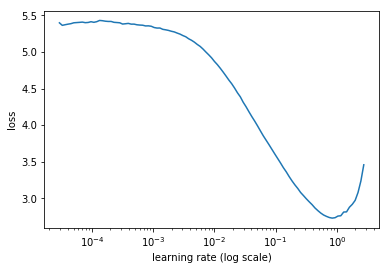

In [25]:
fastai_learn.sched.plot()

In [26]:
fastai_learn.fit(.3,3)

A Jupyter Widget


 34%|███▍      | 44/128 [00:08<00:15,  5.32it/s, loss=1.84]

 36%|███▌      | 46/128 [00:08<00:15,  5.44it/s, loss=1.84]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/jeff/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jeff/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jeff/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




100%|██████████| 128/128 [00:22<00:00,  5.78it/s, loss=1.2]
                                                           [ 0.       1.1952   0.59073  0.84495]

 36%|███▌      | 46/128 [00:09<00:17,  4.60it/s, loss=0.991]


100%|██████████| 128/128 [00:23<00:00,  5.43it/s, loss=0.965]
                                                             [ 1.       0.96507  0.7072   0.84561]

 34%|███▍      | 44/128 [00:09<00:18,  4.53it/s, loss=0.879]


100%|██████████| 128/128 [00:23<00:00,  5.43it/s, loss=1.11]
                                                            [ 2.       1.11225  0.85374  0.83018]

